In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from nengo.solvers import LstsqL2

import pystorm
from pystorm.hal import HAL
from pystorm.hal.net_builder import NetBuilder
from pystorm.hal.run_control import RunControl

In [2]:
# set parameters for network
#   number of neurons
# create the network
#   set tap points - this can be encapsulated and improved later

# what should I set the gain and bias bits to?
# 
X = 16
Y = 16
NNEURON = X*Y
DIM = 1
FMAX = 1000

DOWNSTREAM_NS = 10000

hal = pystorm.hal.HAL()

In [3]:
net_builder = NetBuilder(hal)

bad_syn = hal.get_calibration("synapse", "high_bias_magnitude")
SX = X // 2
SY = Y // 2
tap_matrix_syn = net_builder.create_default_yx_taps(SY, SX, DIM, bad_syn)
tap_matrix = net_builder.syn_taps_to_nrn_taps(tap_matrix_syn)
np.savetxt("tap_matrix.txt", tap_matrix)

In [4]:
gain_divs = np.loadtxt("gain_divisors.txt", dtype=int)
biases = np.loadtxt("biases.txt", dtype=int)
net = net_builder.create_single_pool_net(
    Y, X, tap_matrix, biases=biases, gain_divs=gain_divs, decoders=np.zeros((1, Y*X)))
run_control = RunControl(hal, net)

hal.map(net)

Collect data for training

In [5]:
# collect data for training
# calculate decode weights
#   use linear function offset at 0

bin_size = 0.5 # seconds
bin_size_ns = int(bin_size*1E9)
hal.set_time_resolution(DOWNSTREAM_NS, bin_size_ns)

total_train_points = 11
offset_time = 0.5

train_rates = np.zeros((total_train_points+1, 1))
train_rates[:total_train_points,0] = FMAX * np.linspace(-1, 1, total_train_points)
train_rates[-1, 0] = train_rates[-2, 0]
train_time_ns = np.arange(total_train_points+1)*bin_size_ns
train_time_ns += hal.get_time()

input_obj = net.inputs[0]
input_vals = {input_obj:(train_time_ns, train_rates)}

outputs_data, spike_data = run_control.run_input_sweep(
    input_vals, get_raw_spikes=True, get_outputs=False)

pool_obj = net.pools[0]
spikes, bin_times = spike_data
spikes = spikes[pool_obj]
rates = spikes/bin_size
train_rates = train_rates[:-1]

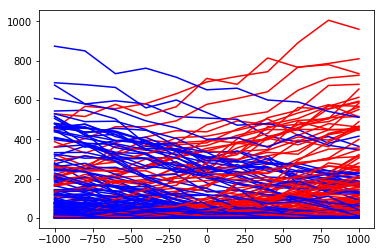

In [6]:
def plot_tuning(inputs, rates):
    n_bins, n_neurons = rates.shape
    nsq = int(np.sqrt(n_neurons))
    half_sq = nsq//2
    for idx in range(nsq):
        start_l = 2*idx*half_sq
        start_r = start_l + half_sq
        plt.plot(inputs, rates[:, start_l:start_l+half_sq], 'r')
        plt.plot(inputs, rates[:, start_r:start_r+half_sq], 'b')
plot_tuning(train_rates, rates)

(11, 256)
(11, 1)
[24.269786]


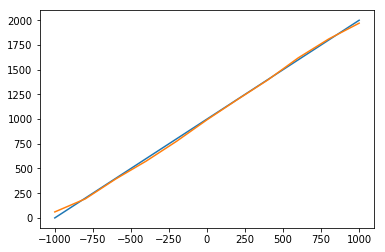

In [7]:
# fit decoders

target_function = train_rates + FMAX
solver = LstsqL2(reg=0.1)
print(rates.shape)
print(target_function.shape)
decoders, info = solver(rates, target_function)
rmse = info['rmses']
print(rmse)
train_decode = np.dot(rates, decoders)
plt.plot(train_rates, target_function)
plt.plot(train_rates, train_decode)

#TODO: collect testing data

In [8]:
net.decoder_conn.reassign_weights(decoders.T)
hal.remap_weights()

In [10]:
# run tests
#  deliver an input of 0
time_resolution_ns = 100000
hal.set_time_resolution(DOWNSTREAM_NS, time_resolution_ns)

test_time = 1
test_time_ns = int(test_time*1E9)

test_rates = np.zeros((2, 1))
test_times = np.arange(2)*test_time_ns + hal.get_time()

input_vals = {input_obj:(test_times, test_rates)}

output_data, spike_data = run_control.run_input_sweep(
    input_vals, get_raw_spikes=True, get_outputs=True)

outputs, output_bin_times = output_data
spikes, spike_bin_times = spike_data
print(outputs)
print(output_bin_times)
print(spikes)
print(spike_bin_times)

{Output o1: array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint32)}
[49869430000 49869530000 49869630000 ... 50804130000 50804230000
 50804330000]
{Pool p1: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)}
[49804430000 49804530000 49804630000 ... 50804130000 50804230000
 50804330000]


### open ideas

- compare to all weights positive and equal
- check for poissonness of superposed spike trains
- sweep decoder magnitude